Required time for initialization (s)	 : 0.002204
Required time for total calculation (s)	 : 2.362756
Required time for calculating a PSF (s)	 : 2.362756
Required time for reconstructor init (s) : 1.411876
Required time for tomography init (s)	 : 0.830715
Required time for optimization init (s)	 : 0.576199
Required time for controller init (s)	 : 0.266894
Required time for otf calculation (s)	 : 0.390538
Required time for error calculation (s)	 : 0.214308
Required time for psf calculation (s)	 : 0.042935


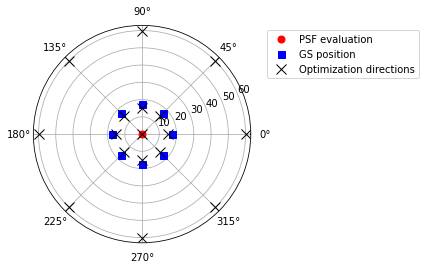

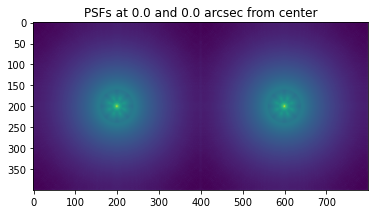

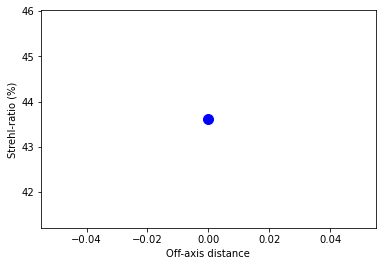

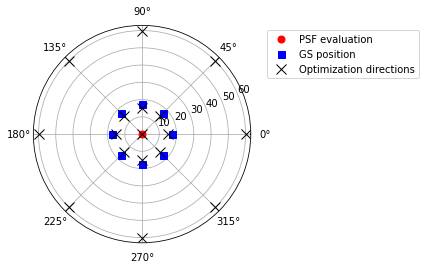

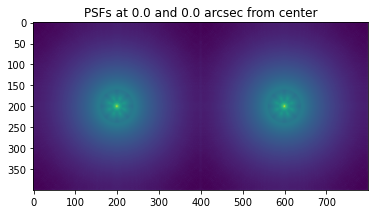

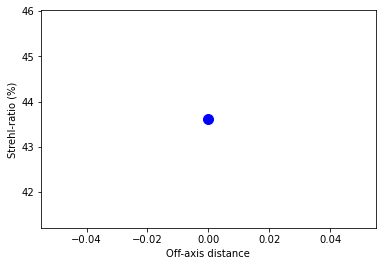

Fourier Model class instantiated


In [1]:
from fourierPSF.fourierModel import *

fao = fourierModel("parFileMAVIS", nyquistSampling=True, calcPSF=True, verbose=False, display=True)
print(fao)

In [2]:
from mavis import *

# calcolo sulla GPU: quasi fatto, maca psd generation (facile) fitting (boh)
# caclolare la psf short exposure (Fatto)
# avendo la psf:
# 1. calcolare il profilo radiale della psf (Fatto)
# 2. n-square energy, energia che sta dentro quadrati di lato crescente (Fatto)
# 3. FWHM ( date le 2 varianze: FWHM = 0.5 * k * sqrt( sigma1 + sigma2)   )
# 4. Strehl ()
# 5. Convoluzione con un kernel della PSF: (Fatto)
#    kernel, nello stesso spazio della psf
# costruzione del kernel a partire da orientamento degli assi (un angolo)
# e matrice di covarianzaoppure le due FWHM ()

# atmosphereWavelength= 500e-9                                                            # Atmosphere wavelength in m
# ScienceWavelength   = 640e-9                                                            # Imaging wavelength [m]

# prima usavamo 550e-9
# SensingWavelength_HO   = 589e-9                                                         # Sensing wavelength in [m]

# SensingWavelength_LO   = 1650*1e-9                                                      # Sensing wavelenth in [m]

path = "/home/frossi/dev/MASTSEL/"
parametersFile = 'mavisParams'
namespace = {}
params_module = __import__(parametersFile, globals(), locals())
exec( open(path + parametersFile + ".py").read(), namespace)
globals().update(vars(params_module))
globals().update(namespace)

In [2]:
Field_size = 1024*4
defaultArrayBackend=cp
f2 = Field(SensingWavelength_HO, Field_size, 32*4, 'm' )
f2.setAsTelescopeMask(4,0)

In [3]:
#%%timeit
#f2.pupilToPsf()

In [4]:
# Field_size = 1024*4
# defaultArrayBackend=np
# f2 = Field(SensingWavelength_HO, Field_size, 32*4, 'm', np, np.float)
# f2.setAsTelescopeMask(4,0)

In [5]:
#%%timeit
#f2.pupilToPsf()

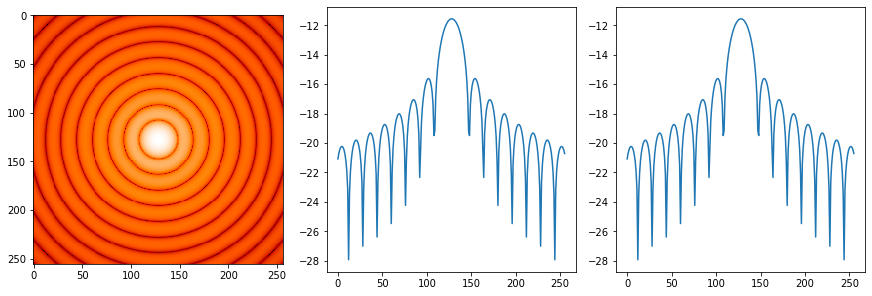

(6.66574514216369e-08, 6.66574514216369e-08)
Wavelength:  5.5e-07
Grid side elements:  4096
width:  1.76e-05 [ rad ]
width:  3630.264 [ mas ]
pixel_size:  4.296875e-09 [ rad ]
pixel_size:  0.886294921875 [ mas ]


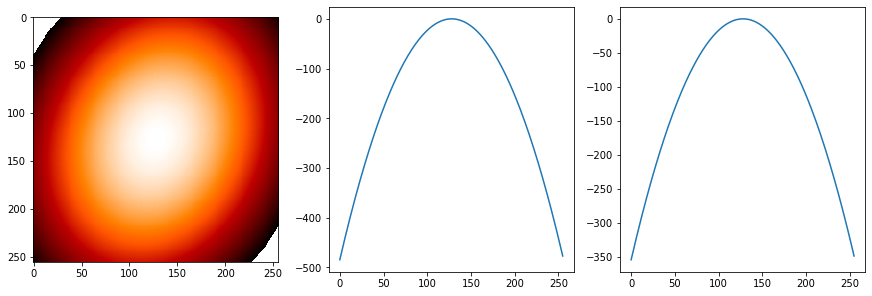

Wavelength:  5.5e-07
Grid side elements:  4096
width:  1.76e-05 [ rad ]
width:  3630.264 [ mas ]
pixel_size:  4.296875e-09 [ rad ]
pixel_size:  0.886294921875 [ mas ]


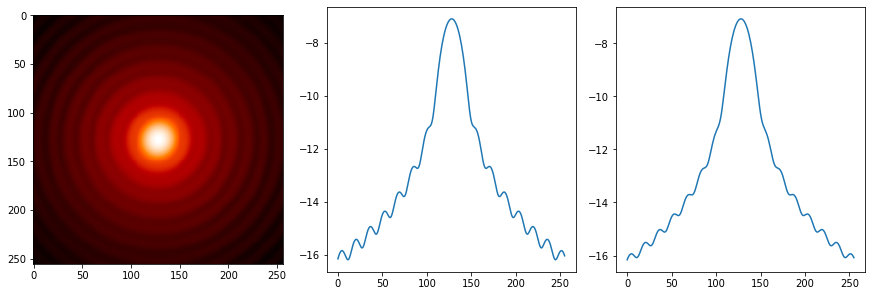

Wavelength:  5.5e-07
Grid side elements:  4096
width:  1.76e-05 [ m ]
pixel_size:  4.296875e-09 [ m ]


/home/frossi/anaconda3/envs/cuda/lib/python3.6/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


(7.717221927023179e-08, 8.297184783758547e-08)


In [6]:
f2 = Field(SensingWavelength_HO, Field_size, 32*4)
f2.setAsTelescopeMask(4,0)
f2.pupilToPsf()
f2.standardPlot(True, zoom=8)


f1 = Field(SensingWavelength_HO, Field_size, 32*4)
f1.setAsTelescopeMask(4,0)
f1.pupilToPsf()
print(f1.FWHM())

f1.printStatus()

f1.setAsGaussianKernel(f1.pixel_size*4, f1.pixel_size*5, np.pi/8.0)
f1.standardPlot(True, zoom=8)
f1.printStatus()

f3 = convolve(f2, f1)
f3.standardPlot(True, zoom=8)
f3.printStatus()
print(f3.FWHM())

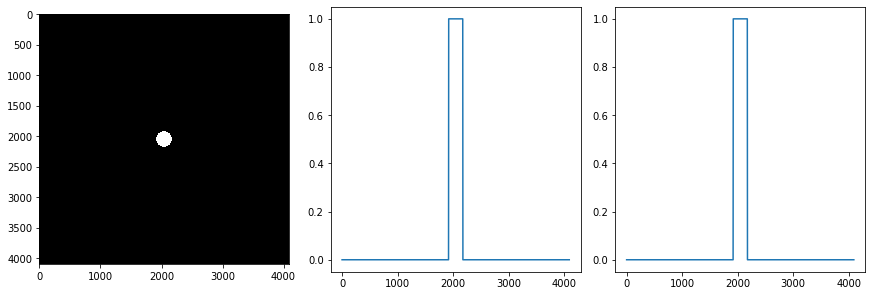

Wavelength:  5.5e-07
Grid side elements:  4096
width:  128.0 [ m ]
pixel_size:  0.03125 [ m ]


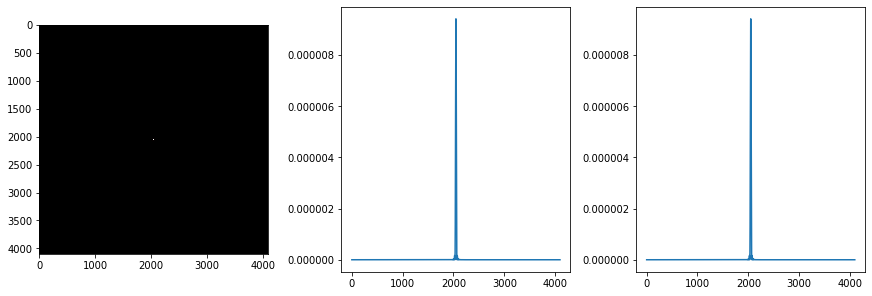

Wavelength:  5.5e-07
Grid side elements:  4096
width:  1.76e-05 [ rad ]
width:  3630.264 [ mas ]
pixel_size:  4.296875e-09 [ rad ]
pixel_size:  0.886294921875 [ mas ]


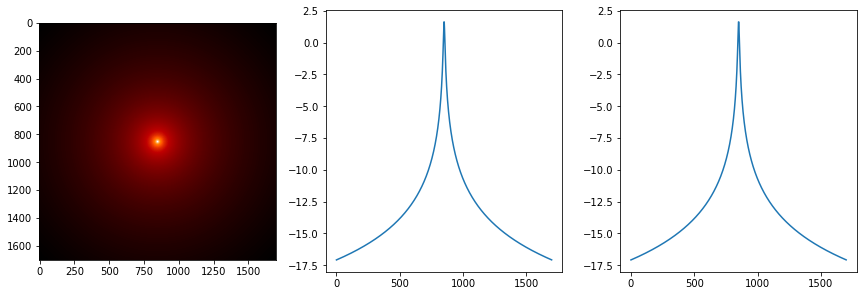

Wavelength:  5.5e-07
Grid side elements:  1700
width:  13.281250000000004 [ m ]
pixel_size:  0.007812500000000002 [ m ]


In [7]:
f1 = Field(SensingWavelength_HO, Field_size, 16*TelescopeDiameter)
f1.setAsTelescopeMask(TelescopeDiameter/2,0)
f1.standardPlot()
f1.printStatus()

f1.pupilToPsf()
#f1.pupilToOtf()
f1.standardPlot()
f1.printStatus()

f2 = Field(SensingWavelength_HO, 1700, 16*TelescopeDiameter)

# r0 = 0.8
r0 = 0.976*atmosphereWavelength/seeing*206264.8 # old: 0.15        
# 'Kolmogorov' does not us l0_, before we used 'VonKarman'
l0_ = 0.005
f2.setAsPSD(16*TelescopeDiameter, r0, L0, l0_, 'Kolmogorov')
f2.standardPlot(True)
f2.printStatus()

# _, _, f_turb = turbolenceFormulas.getFormula('phaseSpatialPowerSpectrumVonKarman')
# r0 = 0.9759 * 0.5/(seeing*4.848)
# vk_l[*,*,i] = (24/5.*gamma(6/5.))^(5./6)*gamma(11/6.)^2/(2*!pi^(11./3))*r0^(-5./3)*(freqs_x^2.+freqs_y^2.+1./L0^2.)^(-11./6)

grid_diameter: 30.45523489932886
up_factor: 4


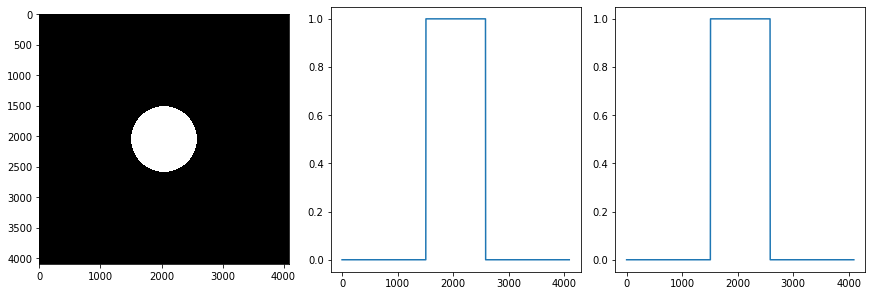

Wavelength:  5.5e-07
Grid side elements:  4096
width:  30.45523489932886 [ m ]
pixel_size:  0.00743536008284396 [ m ]


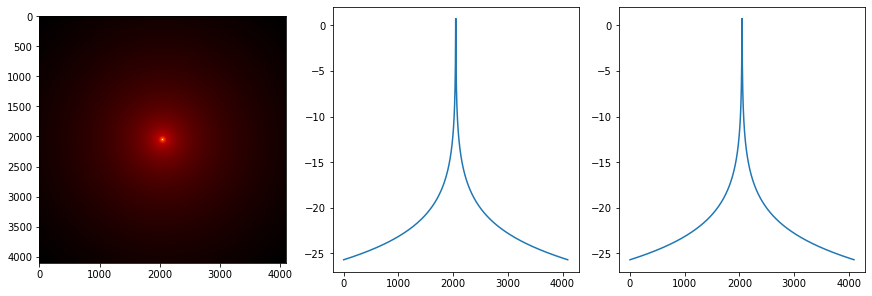

Wavelength:  5.5e-07
Grid side elements:  4096
width:  134.49247768206388 [ m ]
pixel_size:  0.03283507755909763 [ m ]


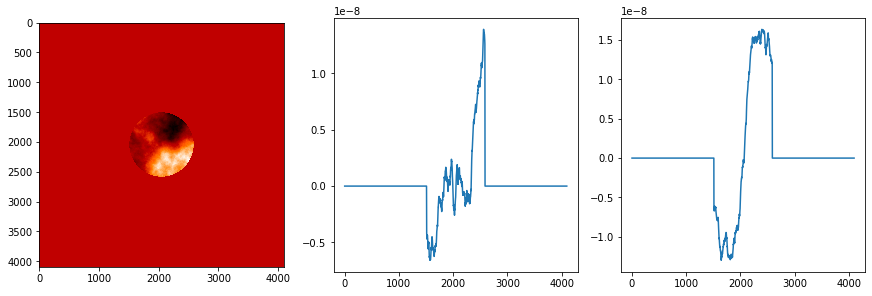

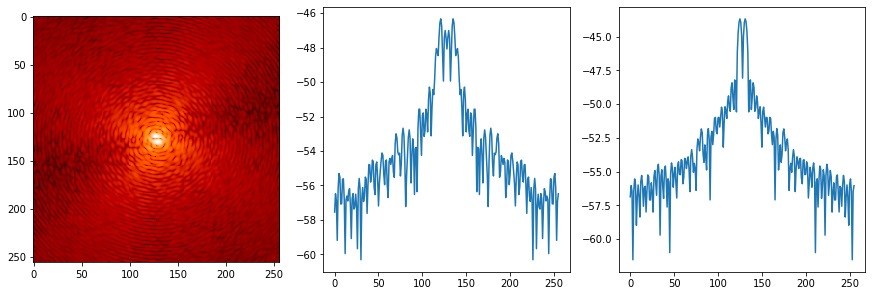

Wavelength:  5.5e-07
Grid side elements:  4096
width:  7.397086272513514e-05 [ rad ]
width:  15257.6 [ mas ]
pixel_size:  1.8059292657503697e-08 [ rad ]
pixel_size:  3.725 [ mas ]
Diffraction limeted psf peak: 0.0030715437133552203
Actual psf peak: 6.994027699798717e-20
Strehl: 2.2770399357783342e-17


In [8]:
N = Field_size
wvl = SensingWavelength_HO # lambda
pixel_psf = 14.9 # mas
tel_radius = TelescopeDiameter/2

fit_factor = 3.0
up_factor = 1

pixel_psf_upsampled = (pixel_psf / up_factor) / radiansToMas
pitch = wvl / (pixel_psf_upsampled * N) # rad

while pitch*N < 2*tel_radius*fit_factor:
    up_factor += 1
    pixel_psf_upsampled = (pixel_psf / up_factor) / radiansToMas
    pitch = wvl / (pixel_psf_upsampled * N) # rad

grid_diameter = pitch*N
    
print('grid_diameter:', grid_diameter)
print('up_factor:', up_factor)

freq_range = 1.0/pitch

mask = Field(wvl, N, pitch*N)
mask.setAsTelescopeMask(tel_radius, 0)
mask.standardPlot()
mask.printStatus()

psd = Field(wvl, N, freq_range)

#r0 = 0.8
r0 = 0.976*atmosphereWavelength/seeing*206264.8 # old: 0.15        
# 'Kolmogorov' does not us l0_, before we used 'VonKarman'
l0_ = 0.005
psd.setAsPSD(grid_diameter, r0, L0, l0_, 'Kolmogorov')
psd.standardPlot(True)
psd.printStatus()

#myResult= longExposurePsf(mask, psd)
#myResult.normalize()
##myResult.downSample(up_factor)
#myResult.standardPlot(True)
#myResult.printStatus()

psd.PSDToPhaseScreen()
phaseScreen = psd
myResult2= shortExposurePsf(mask, phaseScreen)
#myResult2.normalize()
#myResult2.downSample(up_factor)
myResult2.standardPlot(True, zoom=8)
myResult2.printStatus()


print( 'Strehl:', StrehlFromMask(myResult2, mask ) )

15.999996967087965
2.876368974318885
max residual: 7.204483439625396e-20


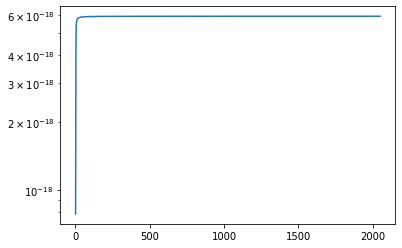

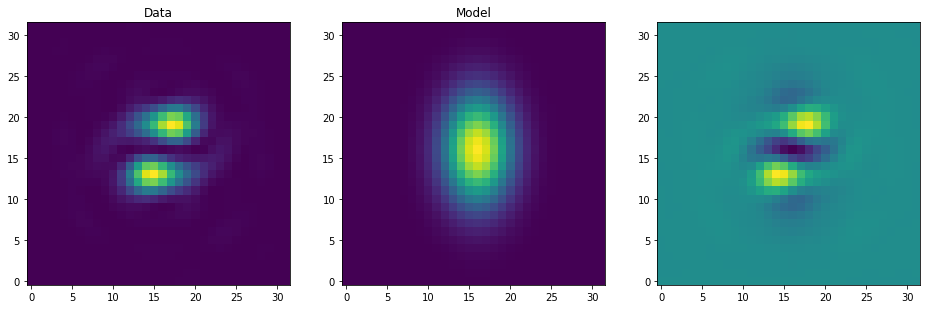

In [9]:
    
#pp = myResult.radial_profile([myResult.N/2.0, myResult.N/2.0] )
#plt.plot( xp.log( pp ) )

pp = myResult2.n_square_energy([myResult2.N/2.0, myResult2.N/2.0] )
plt.xscale('linear')
plt.yscale('log')
plt.plot( hostData(cp.asarray(cp.arange(1,myResult2.N/2.0+2))), hostData(pp) )

nn=32
s1 = centralSquare(myResult2.sampling, nn)
z = hostData(cp.copy(s1))
y, x = np.mgrid[:nn, :nn]
fit_p, p_init = fitGaussian(z)
p = fit_p(p_init, x, y, z)

print(p.x_mean.value)
print(p.x_stddev.value)

plt.figure(figsize=(8*2, 5))
plt.subplot(1, 3, 1)
plt.imshow(z, origin='lower', interpolation='nearest')
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(x, y), origin='lower', interpolation='nearest')
plt.title("Model")
plt.subplot(1, 3, 3)
residual = z - p(x, y)
print('max residual:', np.max(residual))
plt.imshow(residual, origin='lower', interpolation='nearest')
# plt.title("Residual")


In [10]:
# pup_plane_width = 0.0024986730 # pixel size in pupil plane in arcsec
pitch = 0.0564706 # meters, pixel size of the mask
freq_range = 1.0/pitch
N = 1700
wvl = SensingWavelength_HO # lambda

mask = Field(wvl, N, pitch*N)
mask.loadSamplingFromFile('data/MASK4fabio.fits')

psd = Field(wvl, N, freq_range)
psd.loadSamplingFromFile('data/PSD4fabio.fits')

# .... wrong width and unit ....
result = Field(wvl, N, 32*4)
result.loadSamplingFromFile('data/PSF4fabio.fits')
result.normalize()

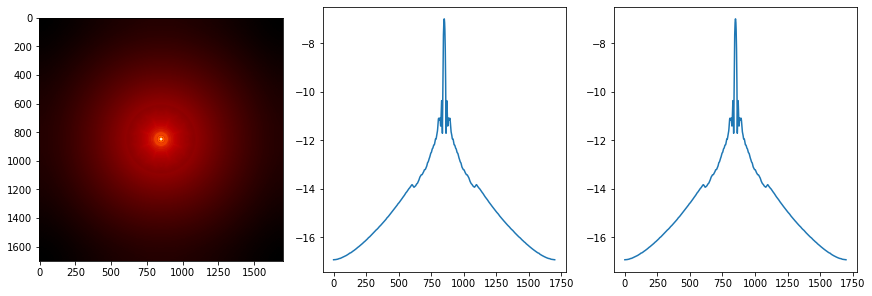

Wavelength:  5.5e-07
Grid side elements:  1700
width:  9.739581304253895e-06 [ rad ]
width:  2008.9347377219297 [ mas ]
pixel_size:  5.729165473090526e-09 [ rad ]
pixel_size:  1.1817263163070173 [ mas ]


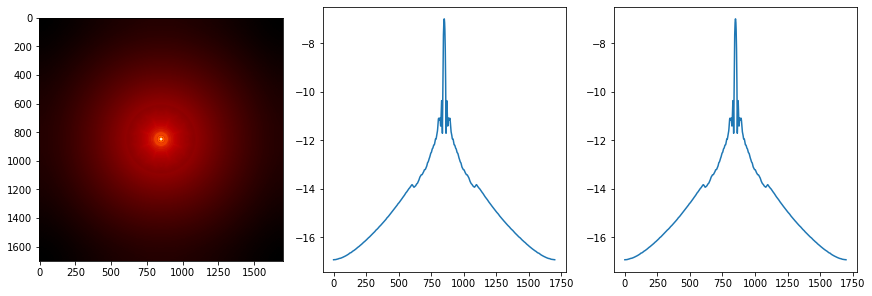

Max of the difference of the two PSFs: 6.146930951228131e-11


In [11]:
myResult= longExposurePsf(mask, psd)
myResult.normalize()
myResult.standardPlot(True)
myResult.printStatus()
result.standardPlot(True)
#twoPsfsPlot(np.asarray(result.sampling), np.asarray(myResult.sampling))
print('Max of the difference of the two PSFs:', np.max(result.sampling-myResult.sampling))